In [25]:
import os
import logging
import json
from typing import Union
from datetime import datetime

import tensorflow as tf
from csbdeep.models import CARE
from csbdeep.data import RawData, create_patches, no_background_patches
from csbdeep.utils import plot_some
from natsort import natsorted
import tifffile as tiff
import numpy as np
from matplotlib import pyplot as plt

In [2]:
assert len(tf.config.list_physical_devices("GPU")) > 0

In [21]:
DATASET_NAME = "20250513_40I_denoising_7to40F"
DATASET_DIREC = "/mnt/d/code/Balu_CARE/datasets"
DATASET_JSON_PATH = os.path.join(DATASET_DIREC, f"{DATASET_NAME}.json")
INPUT_DATA_DIREC = os.path.join("/mnt/d/data/processed/", DATASET_NAME)
TRAIN_DATA_DIREC = os.path.join(INPUT_DATA_DIREC, "train")
FRAMES_LOW = 7
FRAMES_GT = 40
PATCH_SIZE = 128
PATCH_MULTIPLE = 4

In [4]:
low_paths = []
GT_paths = []
for root, dirs, files in os.walk(TRAIN_DATA_DIREC):
    for f in files:
        if f"frames{FRAMES_LOW}" in f:
            low_paths.append(os.path.join(root, f))
        elif f"frames{FRAMES_GT}" in f:
            GT_paths.append(os.path.join(root, f))

low_paths = natsorted(low_paths)
GT_paths = natsorted(GT_paths)

In [5]:
for f1, f2 in zip(low_paths, GT_paths):
    id1 = os.path.basename(f1).split('_')[0]
    id2 = os.path.basename(f2).split('_')[0]
    assert id1 == id2


In [6]:
def min_max_norm(arr: np.array, mini: Union[np.array, int, float], maxi: Union[np.array, int, float], sigma: float=1e-20) -> np.array:
    """
    Min-Max normalized given array based on provided 'mini' and 'maxi'
    """
    if type(mini) == np.array:
        assert mini.ndim == 1, f"Expected array of shape (N, ) not shape {mini.shape}"
        assert mini.shape == arr.shape or mini.shape[0] == arr.shape[-1], f"If mini/maxi are np.array, their Dim should match Arr"
    if type(maxi) == np.array:
        assert maxi.ndim == 1, f"Expected array of shape (N, ) not shape {maxi.shape}"
        assert maxi.shape == arr.shape or maxi.shape[0] == arr.shape[-1], f"If mini/maxi are np.array, their Dim should match Arr"
    assert arr.ndim <= 3, f"Input array should have 3 or fewer dimensions, not shape {arr.shape}"

    return (arr - mini) / (maxi - mini + sigma)
    

In [7]:
ds_config = json.load(open(DATASET_JSON_PATH, 'r'))
input_config = ds_config['FLAME_Dataset']['input']
output_config = ds_config['FLAME_Dataset']['output']

In [8]:
input_1pct, input_99pct = np.array(input_config['pixel_1pct']), np.array(input_config['pixel_99pct'])
output_1pct, output_99pct = np.array(output_config['pixel_1pct']), np.array(output_config['pixel_99pct'])

In [9]:
low = [min_max_norm(
    tiff.imread(path).transpose(1, 2, 0).astype(np.float64), 
    input_1pct, input_99pct
) for path in low_paths]

GT = [min_max_norm(
    tiff.imread(path).transpose(1, 2, 0).astype(np.float64), 
    output_1pct, output_99pct
) for path in GT_paths]

In [10]:
low = np.stack(low, axis=-1).astype(np.float32).transpose(3, 2, 0, 1)
GT = np.stack(GT, axis=-1).astype(np.float32).transpose(3, 2, 0, 1)

In [11]:
print(f"Frame7: {low.shape}, {low.dtype}")
print(f"Frame40: {GT.shape}, {GT.dtype}")

Frame7: (36, 3, 1200, 1200), float32
Frame40: (36, 3, 1200, 1200), float32


In [14]:
raw_data = RawData.from_arrays(
    X=low,
    Y=GT,
    axes="SCYX"
)

In [22]:
n_patch_per_im = low.shape[-1] // PATCH_SIZE * 2

X, Y, XY_axes = create_patches(
    raw_data=raw_data,
    patch_size=(low.shape[1], PATCH_SIZE, PATCH_SIZE),
    patch_axes="CYX",
    patch_filter=no_background_patches(0),
    n_patches_per_image=low.shape[-1] // PATCH_SIZE * PATCH_MULTIPLE,
    normalization=None,
    save_file=os.path.join(INPUT_DATA_DIREC, f"{DATASET_NAME}_patch{PATCH_SIZE}_{n_patch_per_im}PpI.npz")
)

   36 raw images x    1 transformations   =    36 images
   36 images     x   36 patches per image =  1296 patches in total
Input data:
numpy array
Transformations:
1 x Permute axes to CYX
Patch size:
3 x 128 x 128


100%|██████████| 36/36 [00:04<00:00,  8.48it/s]


Saving data to /mnt/d/data/processed/20250513_40I_denoising_7to40F/20250513_40I_denoising_7to40F_patch128_18PpI.npz.


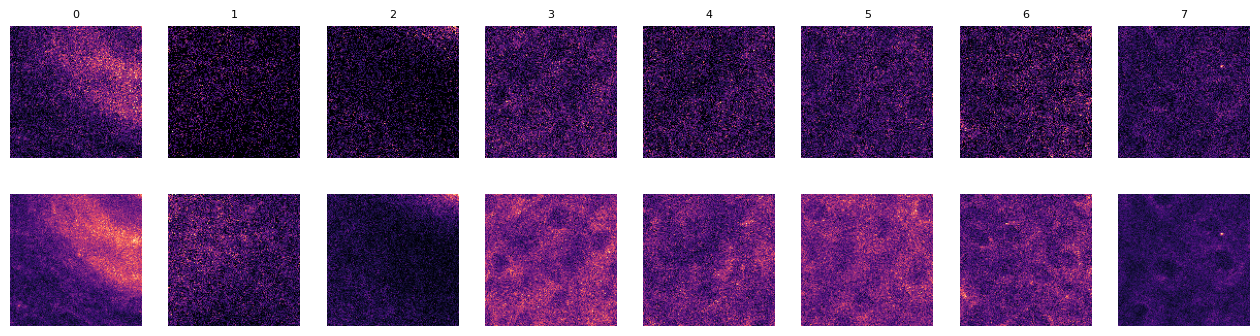

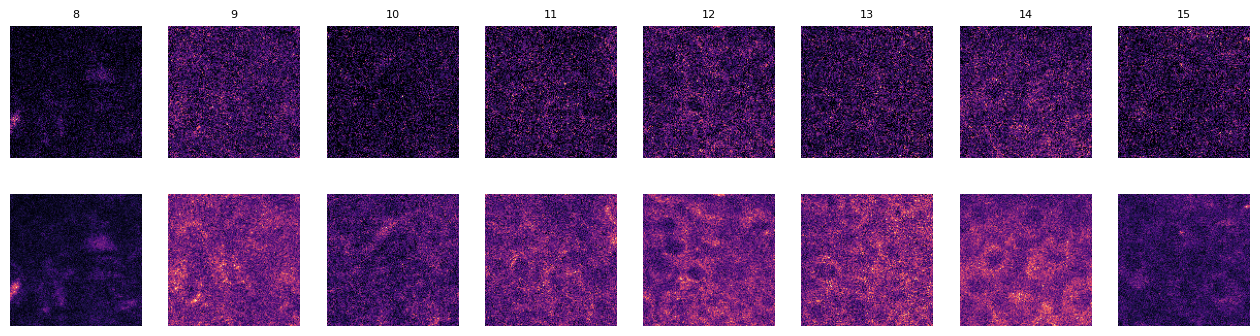

In [ ]:
# from: https://nbviewer.org/url/csbdeep.bioimagecomputing.com/examples/denoising2D/1_datagen.ipynb
for i in range(2):
    plt.figure(figsize=(16,4))
    sl = slice(8*i, 8*(i+1)), 0
    plot_some(
        X[sl],
        Y[sl],
        title_list=[np.arange(sl[0].start,sl[0].stop)],
    )
    plt.show()
None;